In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator, NeuralLFM
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import plot_spatiotemporal_data, tight_kwargs, Plotter2d

params torch.Size([4000, 5])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


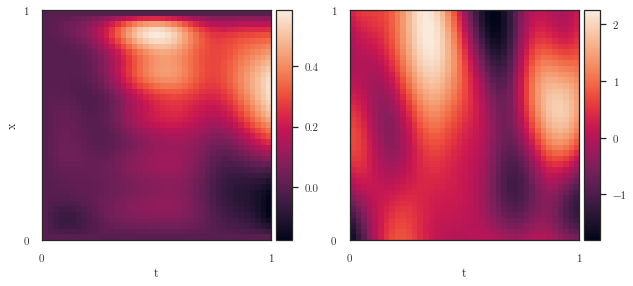

In [2]:
ntest = 50

dataset = ReactionDiffusion('../../../data', nn_format=True, max_n=4000, ntest=ntest)
batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)


params torch.Size([50, 5])
params torch.Size([50, 5])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


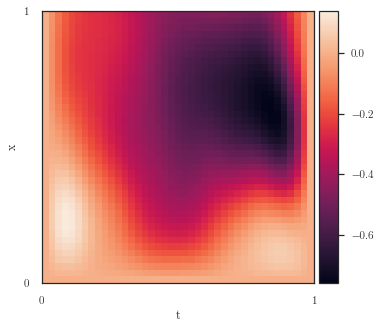

In [3]:
dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 12
width = 38
in_channels = 3


In [4]:
model = NeuralOperator(block_dim, in_channels, 2, modes, width, num_layers=4)
# r_dim = z_dim = 16
# model = NeuralLFM(block_dim, in_channels,
#                   modes, width, r_dim, z_dim)

print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

36696823


In [28]:
state_dict = torch.load('../nn/saved_model1505.pt')
model = NeuralOperator(block_dim, in_channels, 2, modes, width, num_layers=4)
print(model.count_params())
model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

36696823


In [34]:
trainer.train(10);

Epoch 011/020 - Loss: 0.10 (0.41 0.02 0.17 0.01 0.06)
Epoch 012/020 - Loss: 0.10 (0.37 0.03 0.15 0.01 0.06)
Epoch 013/020 - Loss: 0.07 (0.31 -0.00 0.12 0.01 0.06)
Epoch 014/020 - Loss: 0.05 (0.35 -0.03 0.14 0.01 0.07)
Epoch 015/020 - Loss: 0.05 (0.36 -0.02 0.15 0.01 0.07)
Epoch 016/020 - Loss: 0.06 (0.41 -0.01 0.18 0.01 0.06)
Epoch 017/020 - Loss: 0.11 (0.36 0.04 0.15 0.01 0.06)
Epoch 018/020 - Loss: 0.05 (0.32 -0.02 0.13 0.01 0.07)
Epoch 019/020 - Loss: 0.03 (0.37 -0.04 0.15 0.01 0.07)
Epoch 020/020 - Loss: 0.03 (0.35 -0.05 0.14 0.01 0.06)


In [30]:
def show_result(model, loader, plot_uncertainty=False, plotter=None):
    x, y, params = next(iter(loader))
    p_y_pred, params_out = model.predict_f(x)
    mean = p_y_pred.mean[0]
    std  = p_y_pred.variance.sqrt()[0]

    num_t = x.shape[1]
    num_x = x.shape[2]
    if not plot_uncertainty:
        plot_spatiotemporal_data(
            [
                mean[...].detach().view(num_t, num_x).t(),
                y[0, ...].view(num_t, num_x).t(), #num_t
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )
    else:
        a = np.zeros((41, 41, 4))
        a[:, :, 0] = mean
        a[:, :, 0] = (a[:, :, 0] - a[:, :, 0].min()) / (a[:, :, 0].max() - a[:, :, 0].min())
        a[:, :, 3] = std
        a[:, :, 3] = 1-(a[:, :, 3] - a[:, :, 3].min()) / (a[:, :, 3].max() - a[:, :, 3].min())
        plt.imshow(a, origin='lower', extent=extent)
        plt.colorbar()

    plotter.plot_double_bar(
        params_out[0:1],
        ['l1', 'l2', 'sens', 'decay', 'diff'],
        ground_truths=params[0:1],
        figsize=(5, 3)
    )
    out = mean.squeeze()
    y_target = y.squeeze()

    print(params_out[0].detach(), params[0])
    print(F.mse_loss(out, y_target))
    # from lafomo.utilities.torch import smse, q2
    # print(y.shape, f_mean_test.shape)
    # print(smse(y_target, f_mean_test).shape)

torch.Size([50, 41, 41]) torch.Size([50, 41, 41])
torch.Size([50, 41, 41]) torch.Size([50, 41, 41])
tensor([0.1666, 0.3205, 0.6951, 0.2132, 0.0311]) tensor([0.4000, 0.1750, 0.5000, 0.1075, 0.0208])
tensor(2.0106)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([50, 41, 41])) that is different to the input size (torch.Size([41, 41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


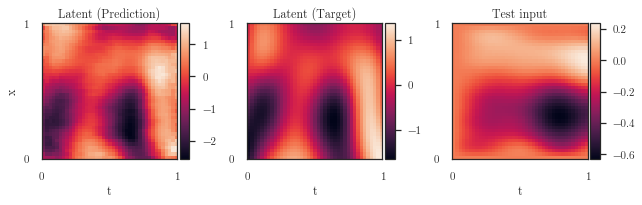

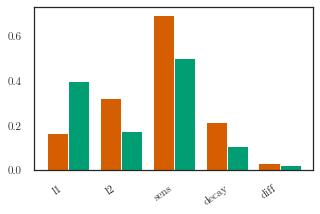

In [31]:
plotter = Plotter2d(model, np.array(['']))

show_result(model, test_loader, plotter=plotter)

torch.Size([50, 41, 41]) torch.Size([50, 41, 41])
torch.Size([50, 41, 41]) torch.Size([50, 41, 41])
tensor([3.4110e-01, 4.0546e-01, 9.4743e-01, 1.7418e-01, 5.6069e-04]) tensor([0.3000, 0.3000, 1.0000, 0.1000, 0.0100])
tensor(2.4097)
torch.Size([50, 81, 81]) torch.Size([50, 81, 81])
torch.Size([50, 81, 81]) torch.Size([50, 81, 81])
tensor([ 0.7591,  0.7573,  3.0822,  0.5984, -0.0514]) tensor([0.3000, 0.3000, 1.0000, 0.1000, 0.0100])
tensor(2.0022)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([50, 41, 41])) that is different to the input size (torch.Size([41, 41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([50, 81, 81])) that is different to the input size (torch.Size([81, 81])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


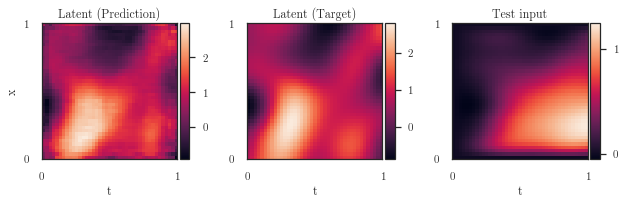

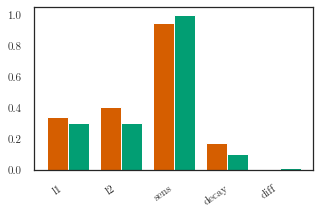

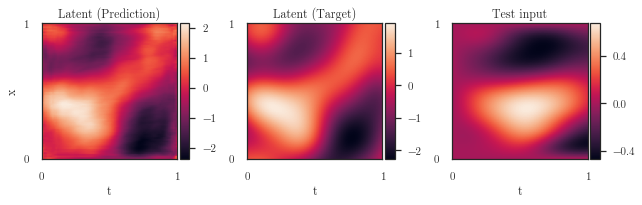

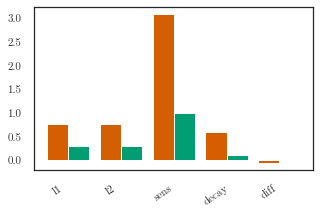

In [33]:
show_result(model, subsampled_loader, plotter=plotter)
show_result(model, high_res_loader, plotter=plotter)

In [24]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from scipy.interpolate import interp1d
dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True, nn_format=True)


x = interp1d(np.linspace(0, 1, 8), dataset.train_data[0][0], axis=0)(np.linspace(0, 1, 64))
x1 = interp1d(np.linspace(0, 1, 8), dataset.train_data[0][1], axis=0)(np.linspace(0, 1, 64))
print('here', dataset.train_data[0][2].shape, x1.shape)
dataset.train_data[0] = (
    torch.tensor(x, dtype=torch.float32),#dataset.train_data[0][0],#.permute(1, 0, 2),
    torch.tensor(x1, dtype=torch.float32),
    dataset.train_data[0][2]
)
print(dataset.train_data[0][0].shape)
dros_loader = DataLoader(dataset.train_data)

show_result(model, dros_loader)

RuntimeError: shape '[1, 4, 4, 2]' is invalid for input of size 8

torch.Size([41, 41, 3]) torch.Size([41, 41, 1])
torch.Size([8, 64, 3])


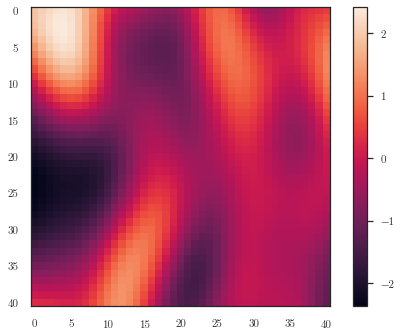

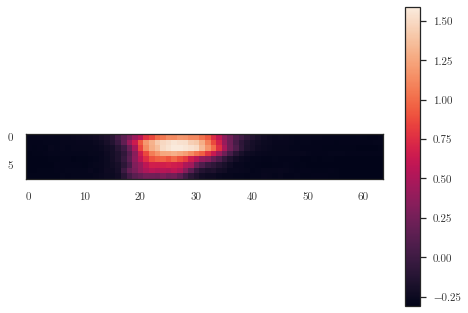

In [61]:
grids = train_loader.dataset[0][0]
gridlf = train_loader.dataset[0][1]
print(grids.shape, gridlf.shape)
plt.imshow(grids[:, :, 0])
plt.imshow(gridlf[:, :, 0])
plt.colorbar()
plt.figure()
grids = dros_loader.dataset[0][0]
gridlf = dros_loader.dataset[0][1]

print(grids.shape)
plt.imshow(grids[:, :, 0])
plt.imshow(gridlf[:, :, 0])

plt.colorbar()

In [47]:
torch.save(model.state_dict(), './saved_model1505.pt')

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
# plt.savefig('toy48.pdf', **tight_kwargs)

params torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 41, 41, 2])
41 41 torch.Size([1, 41, 41, 3]) torch.Size([41, 41])
tensor([0.1800, 0.2280, 0.1824, 0.0113]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.1076)


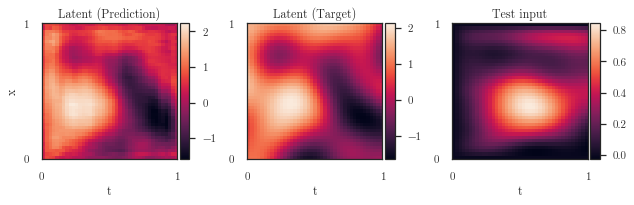

In [19]:
dataset = HomogeneousReactionDiffusion('../../../data', one_fixed_sample=True, nn_format=True, ntest=0)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)